## Nbdev import session

In [1]:
#default_exp kernel

In [2]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [3]:
#export
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from scipy import sparse
import numpy as np

from fkausality.neighbors import FastJaccardNN, FastKLDivNN, FastL2NN
from fkausality.utils import hstack, sparsify, RobustEncoder

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X, y = make_classification(
    n_samples = 10_000,
    n_features = 3,
    n_informative = 3,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 3,
    n_clusters_per_class = 2,
    hypercube = True,
)

plt.clf()
blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

<Figure size 432x288 with 0 Axes>

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


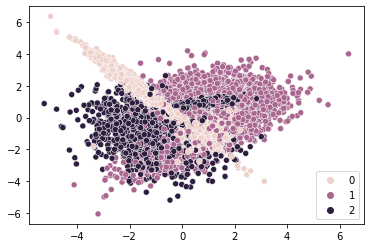

In [6]:
import matplotlib.pyplot as plt
plt.clf()
sns.scatterplot(*X.T[:2], hue = y)
plt.show()

In [7]:
#export
class EstimatorKernel(BaseEstimator, TransformerMixin):    
    '''
    creates a kernel with some specified estimator.
    projection method will be performed according to projection_method.
    projection method can be a string refering to estimators method used to project,
    or a callable, that receives the estimator and X (vector to be projected) as the inputs.
    should return the projections of X according to estimator.
    norm will normalize vectors in matrices prior to applying dot products.
    '''
    def __init__(self, estimator, projection_method, nearest_neighbors_estimator, n_neighbors = 30):
        '''
        creates a kernel with some specified estimator.
        projection method will be performed according to projection_method.
        projection method can be a string refering to estimators method used to project,
        or a callable, that receives the estimator and X (vector to be projected) as the inputs.
        should return the projections of X according to estimator.
        norm will normalize vectors in matrices prior to applying dot products.
        '''
        self.estimator = estimator
        self.projection_method = projection_method
        self.nearest_neighbors_estimator = nearest_neighbors_estimator
        self.n_neighbors = n_neighbors
    
    def __getattr__(self, attr):
        '''
        Allows accessing self.estimator attributes if not found in first object level
        '''
        return getattr(self.estimator, attr)
    
    def transform(self, X):
        '''
        projects X into new space, according to projection_method
        '''        
                        
        if callable(self.projection_method):
            return self.projection_method(self.estimator, X)
        else:
            return getattr(self.estimator, self.projection_method)(X)
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        '''
        X is the feature space,
        y is used only for supervised Kernels
        save_values are values associated with each "Embeding". During transform,
        the values of saved_values are retrieved according to indexes returned by Nearest Neighbor query        
        '''
        if not save_values is None:
            if not len(save_values) == len(X):
                raise IndexError(f'X and save_values must have the same shape along the first dimension. Got {X.shape} and {save_values.shape}')
        
        self.estimator.fit(X, y, **kwargs)
        
        #make space transformation
        train_projection_space_ = self.transform(X) #saves projection space of X in train
        
        if save_values is None:            
            save_values = np.empty((X.shape[0], 0)) #empty array        
                
        #fit index
        self.nearest_neighbors_estimator.fit(train_projection_space_)
        
        #save states
        self.train_projection_space_ = train_projection_space_
        self.train_projection_values_ = save_values
        return self
        
    def dist_matrix(self, A, B,  n_neighbors = 30, remove_diagonal = False):
        '''
        reeturns pariwise_dist of X and self.train_projection_space_
        if X is None, returns pariwise similarity of self.train_projection_space_ with itself
        '''
        raise NotImplementedError
        
            
    def kneighbors(self, X = None, n_neighbors = None, return_distance = True):
        '''
        runs nearest neighbor search in the transformed space index
        '''        
                    
        if n_neighbors is None:
            n_neighbors = self.n_neighbors
            
        #make space transformation
        X = self.transform(X)
        #query in index
        result = self.nearest_neighbors_estimator.kneighbors(X, n_neighbors = n_neighbors, return_distance = return_distance)
                
        return result #dist, idxs
    
    def query(self, X = None, n_neighbors = None):
        '''
        same as kneighbors, but instead of returning indexes, returns values in self.train_projection_values_
        '''
        idxs, dist = self.kneighbors(X, n_neighbors, return_distance = True)
        values = [self.train_projection_values_[idx] for idx in idxs]
        return values, dist
    
    def update_space(self, X, save_values = None):
        '''
        updates self.train_projection_space_ and self.train_projection_values_ with new data.
        new values are found running self.transform on X
        '''
        X = self.transform(X)
        
        self.train_projection_space_ = vstack([self.train_projection_space_, X])
        
        if save_values is None:            
            save_values = np.empty((X.shape[0], self.train_projection_values_.shape[-1])) #empty array
            
        
        #refit knn index
        self.nearest_neighbors_estimator.fit(self.train_projection_space_)
        
        self.train_projection_values_ = vstack([self.train_projection_values_, save_values])        
        return self

In [8]:
#export
class JaccardForestKernel(EstimatorKernel):
    '''
    A Space tranformation performed based on Forest transformations.
    Can be supervised or not (CARTs, RandomTreeEmbeddings, Boosted trees...)
    
    the embedding_space is sparse and can be defined as the `decision_path` space or `terminal_nodes`
    space.
    '''             
    
    def __init__(
        self,
        estimator,
        n_neighbors = 30,
        index_time_params={'M': 30, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0},
        query_time_params={'efSearch': 100},
        verbose = False
    ):
        
        #save init params for sklearn consistency
        self.n_neighbors = n_neighbors
        self.index_time_params=index_time_params
        self.query_time_params=query_time_params
        self.verbose=verbose
        
        #instantiate jacard distance nearest neighbor index
        nn_obj = FastJaccardNN(
            n_neighbors = n_neighbors,
            index_time_params=index_time_params,
            query_time_params=query_time_params,
            verbose=verbose,
        )
                        
        super().__init__(
            estimator = estimator,
            projection_method=None,
            nearest_neighbors_estimator=nn_obj,
            n_neighbors=n_neighbors            
        )        
        
        return
    
    def transform(self, X):
        
        X = self.estimator.apply(X)
        #handle boosting case
        if len(X.shape) > 2:
            X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
            
        if hasattr(self, 'one_hot_node_embeddings_encoder_'):            
            X = self.one_hot_node_embeddings_encoder_.transform(X)

        else:            
            self.one_hot_node_embeddings_encoder_ = OneHotEncoder().fit(X)
            X = self.one_hot_node_embeddings_encoder_.transform(X)
                            
        return X 

In [9]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
fkernel = JaccardForestKernel(GradientBoostingClassifier())
fkernel.fit(X, y, save_values = y)

JaccardForestKernel(estimator=GradientBoostingClassifier())

In [10]:
fkernel.query(X[:2])

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
#export
class CategoricalLinearKernel(EstimatorKernel):    
    '''
    Linear model kernel recommended for high cardinality one hot encoded categorical variables.
    kernel space is defined by liner model coefficients indexed by the nonzero elements
    of X
    
    If encode is set to true, a customized onehotencoder will encode the categorical input.
    
    This kernel will only work if the output of the one hot encoded vectors  have always the same number
    of nonzero elements (equal to the number of categorical features). Thus, its recomended to use the default
    encoder, because it asserts this condition is met during one hot encoding
    '''
    
    def __init__(
        self,
        estimator,
        n_neighbors=30,
        encode = False,
        n_components = None,
        index_time_params={'M': 30, 'indexThreadQty': 8, 'efConstruction': 100, 'post': 0},
        query_time_params={'efSearch': 100},
        verbose=False,
        **pcakwargs
    ):
        
        self.encode = encode
        self.n_components = n_components
        self.pcakwargs = pcakwargs
        self.estimator = estimator
                
        #save init params for sklearn consistency
        self.n_neighbors = n_neighbors
        self.index_time_params=index_time_params
        self.query_time_params=query_time_params
        self.verbose=verbose
        
        #instantiate jacard distance nearest neighbor index
        nn_obj = FastL2NN(
            n_neighbors = n_neighbors,
            index_time_params=index_time_params,
            query_time_params=query_time_params,
            verbose=verbose,
        )
                        
        super().__init__(
            estimator = estimator,
            projection_method=None,
            nearest_neighbors_estimator=nn_obj,
            n_neighbors=n_neighbors            
        )        
                
        return    
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        
        if self.encode:            
            if not self.n_components is None:
                self.estimator = make_pipeline(RobustEncoder(), self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                self.estimator = make_pipeline(RobustEncoder(), self.estimator)
        else:
            if not self.n_components is None:
                self.estimator = make_pipeline(self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                pass
                                
        return super().fit(X, y, save_values, **kwargs)
    
    def transform(self, X):
        '''
        multiplies sparse vector to its coef_ s from linear model.
        if multiclass classification, the number of final features will be
        n*original_n_features_before_one_hot_encoding
        '''
        
        if self.encode:
            coefs = self.estimator[-1].coef_
            X = self.estimator[0].transform(X)
        else:            
            coefs = self.estimator.coef_
        
        #create attr if it does now exist yet:
        #this line is supposed to run only during fit call
        if not hasattr(self,'dim_embeddings_'):
            self.dim_embeddings_ = len(X[0].data)
                
        if len(coefs.shape) == 1:
            coefs = coefs.reshape(1,-1)
        
        embeddings = []
        for dim in range(coefs.shape[0]):
            #assumes all rows have the same ammount of nonzero elements
            dim_embeddings = coefs[dim, X.nonzero()[1]].reshape(X.shape[0], self.dim_embeddings_)
            embeddings.append(dim_embeddings)                    
                
        return hstack(embeddings)
    

In [ ]:
from sklearn.linear_model import SGDRegressor
X_cat = np.random.randint(0,10, size = (10_000, 100)).astype(str)
y_reg = np.random.randn(10_000,1)
cat_kernel = CategoricalLinearKernel(SGDRegressor(), encode = True)
cat_kernel.fit(X_cat, y_reg, save_values = y_reg)

In [ ]:
cat_kernel.query(X_cat[:2])

In [ ]:
#export
class ClassificationLinearBottleneck(MLPClassifier):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)
        

class RegressionLinearBottleneck(MLPRegressor):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)

In [ ]:
#export
def _get_sklearn_mlp_activations(self, X, output_layer = -2):
    hidden_layer_sizes = self.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + \
        [self.n_outputs_]
    activations = [X]
    for i in range(self.n_layers_ - 1):
        activations.append(np.empty((X.shape[0],
                                     layer_units[i + 1])))
    self._forward_pass(activations)
    return activations[output_layer]

In [ ]:
#export
class MLPKernel(EstimatorKernel):
    
    '''
    returns the output of last hidden layer (before softmax/linear layer)
    as space projection.
    
    Recomended for dimensionality reduction and Context specific bag of words task
    '''    
    def __init__(self, estimator, output_layer = -2, norm='l2'):
        
        self.projection_method = partial(_get_sklearn_mlp_activations, output_layer = output_layer)
        self.estimator = estimator
        self.output_layer = output_layer
        self.norm = norm
        return
    
    

In [ ]:
#export
class BOWKernel(MLPKernel):
    '''
    `MLPKernel` Alias, intended for Bag Of Words application.
    Generates supervised embeddings (context specific embeddings)
    '''
    pass

# Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()